In [797]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
from utils.polygons import get_obj_polygon
from utils.visualize import visualize_polygon

In [798]:
image_path = './data_stage_2/123.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [799]:
import numpy as np

def filter_small_parts_from_tooth_results(tooth_results, min_area=500):
    """
    Filters out small predictions from YOLO results for tooth detection.
    
    Parameters:
        tooth_results (list of Results): YOLO inference results containing `boxes` and `masks`.
        min_area (int): The minimum area threshold for keeping predictions.

    Returns:
        List of filtered predictions (masks and bounding boxes).
    """
    # If the results are a list, we take the first element (assuming single image inference)
    if isinstance(tooth_results, list):
        tooth_results = tooth_results[0]

    filtered_predictions = []

    # Get bounding boxes and masks from YOLO results
    boxes = tooth_results.boxes.xyxy.cpu().numpy()  # Bounding boxes in [x1, y1, x2, y2] format
    masks = tooth_results.masks.cpu().numpy()  # Segmentation masks (if available)

    # Ensure that masks are 3D (num_objects, height, width)
    if len(masks.shape) != 3:
        raise ValueError("Masks should be a 3D array with shape (num_objects, height, width).")
    
    # Loop through predictions and filter by area
    for i, mask in enumerate(masks):
        # Calculate area of the mask (sum of pixels)
        mask_area = np.sum(mask)
        
        # Calculate the area of the bounding box
        x1, y1, x2, y2 = boxes[i]
        bbox_area = (x2 - x1) * (y2 - y1)
        
        # If either the mask area or bounding box area is above the minimum threshold, keep the prediction
        if mask_area >= min_area or bbox_area >= min_area:
            filtered_predictions.append({'mask': mask, 'bbox': boxes[i]})
    
    return filtered_predictions



In [800]:
tooth_detection_model = YOLO("./models/Tooth/best.pt")
tooth_results = tooth_detection_model.predict(image_path, conf=0.80)
                                         

cej_bone_detection_model = YOLO("./models/CEJ_Bone/best.pt")
cej_bone_results = cej_bone_detection_model.predict(image_path, conf=0.5, max_det=2, iou=0.9)


image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/data_stage_2/123.jpg: 512x640 4 tooths, 59.8ms
Speed: 2.7ms preprocess, 59.8ms inference, 3.1ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/data_stage_2/123.jpg: 512x640 1 bone_level, 1 CEJ, 53.9ms
Speed: 3.2ms preprocess, 53.9ms inference, 2.7ms postprocess per image at shape (1, 3, 512, 640)


In [801]:
tooth_results[0].boxes.xyxy.shape

torch.Size([4, 4])

In [802]:
p1 = get_obj_polygon(tooth_results, image)
p2 = get_obj_polygon(cej_bone_results, image)

In [803]:
from shapely.geometry import Polygon

def filter_small_polygons(polygons, min_area=500):
    """
    Filters out polygons with area smaller than the specified threshold.

    Parameters:
        polygons (list of shapely.geometry.Polygon): List of polygons to filter.
        min_area (float): The minimum area threshold for keeping polygons.

    Returns:
        List of shapely.geometry.Polygon: Filtered polygons that have an area larger than `min_area`.
    """
    filtered_polygons = []

    for polygon in polygons:
        # Check if the area of the polygon is greater than or equal to min_area
        if polygon.area >= min_area:
            filtered_polygons.append(polygon)
    
    return filtered_polygons

min_area = 150

# Filter polygons
tooth_polygons = filter_small_polygons(p1['tooth'], min_area)
cej_polygon = filter_small_polygons(p2['CEJ'], min_area)
bone_polygon = filter_small_polygons(p2['bone_level'], min_area)

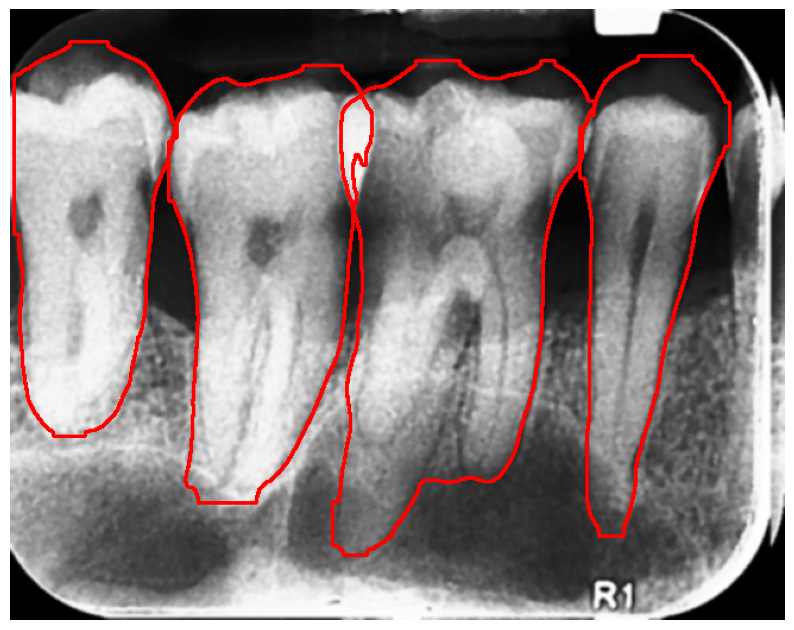

In [804]:
visualize_polygon(tooth_polygons, image)

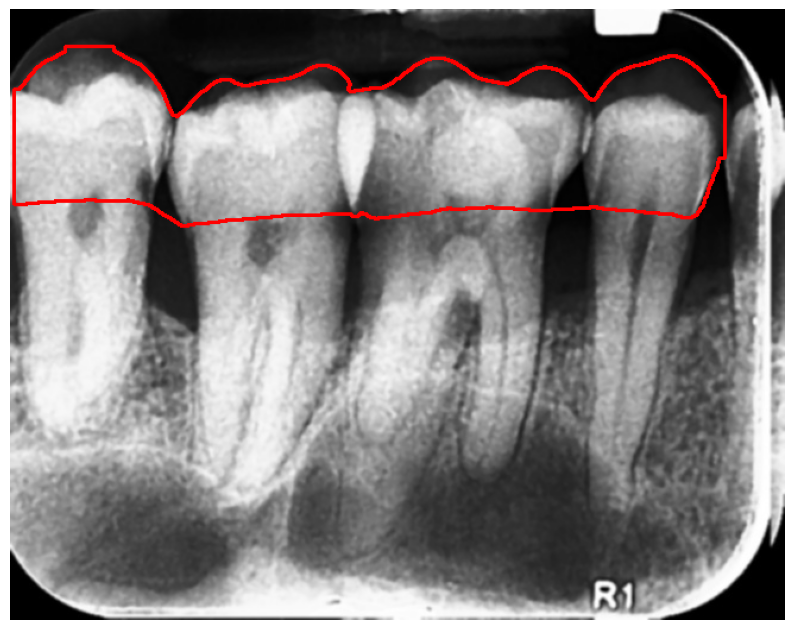

In [805]:
visualize_polygon(cej_polygon, image)

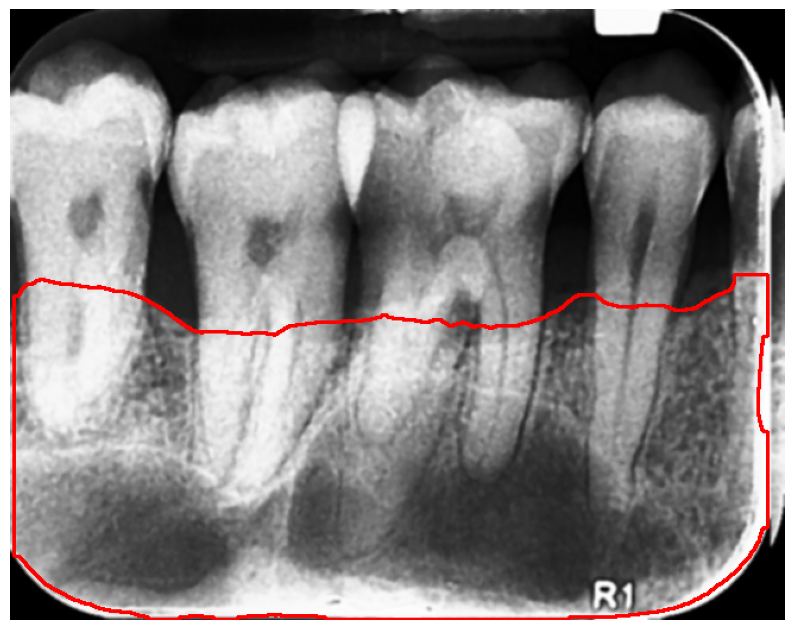

In [806]:
visualize_polygon(bone_polygon, image)

In [807]:
import numpy as np
from shapely.geometry import Polygon, LineString
from sklearn.decomposition import PCA

def get_major_axes(polygons):
    """
    Given a list of polygons, return a list of their major axes as LineStrings.
    
    Parameters:
        polygons (list of shapely.geometry.Polygon): List of polygons.

    Returns:
        List of shapely.geometry.LineString: Major axes of the polygons.
    """
    major_axes = []

    for polygon in polygons:
        # Get exterior coordinates
        x, y = polygon.exterior.xy
        points = np.column_stack((x[:-1], y[:-1]))  # Exclude last point (duplicate of first)

        # Compute centroid
        centroid = np.array([polygon.centroid.x, polygon.centroid.y])

        # Apply PCA to get principal components
        pca = PCA(n_components=2)
        pca.fit(points - centroid)  # Center the points

        # Get major axis direction
        major_axis_dir = pca.components_[0]
        major_length = pca.explained_variance_[0] ** 0.5  # Scale by variance

        # Compute major axis line (extend it for visualization)
        major_axis_start = centroid - major_axis_dir * major_length * 100
        major_axis_end = centroid + major_axis_dir * major_length * 100

        # Convert to LineString
        major_axis_line = LineString([major_axis_start, major_axis_end])
        major_axes.append(major_axis_line)

    return major_axes


In [808]:
major_axes = get_major_axes(tooth_polygons)

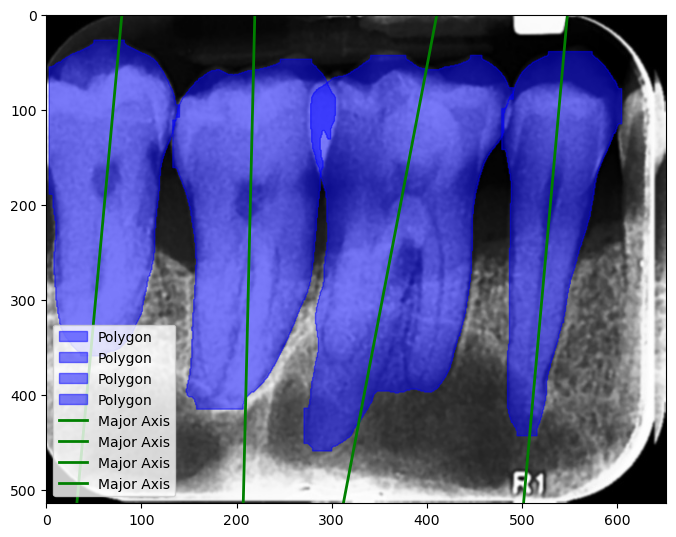

In [809]:
# Plot the image
# Ensure 'image' is a PIL image
if isinstance(image, np.ndarray):
    img = Image.fromarray(image)  # Convert NumPy array to PIL image
else:
    img = image  # Use as-is if already a PIL image
    
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img)

# Plot the polygons
for polygon in tooth_polygons:
    x, y = polygon.exterior.xy
    ax.fill(x, y, alpha=0.5, color='blue', label="Polygon")

# Plot major axes
for axis in major_axes:
    x, y = axis.xy
    ax.plot(x, y, 'g-', linewidth=2, label="Major Axis")

# Set axis limits based on polygon bounds
# x_min = min([poly.bounds[0] for poly in p1['tooth']]) - 20
# x_max = max([poly.bounds[2] for poly in p1['tooth']]) + 20
# y_min = min([poly.bounds[1] for poly in p1['tooth']]) - 20
# y_max = max([poly.bounds[3] for poly in p1['tooth']]) + 20

# ax.set_xlim(x_min, x_max)
# ax.set_ylim(y_max, y_min)  # Invert y-axis for correct image coordinates
# Set full image display limits
ax.set_xlim(0, img.width)
ax.set_ylim(img.height, 0) 
ax.legend()
plt.show()

In [810]:
def plot_results(image, polygons, major_axes, lower_intersections):
    """
    Plots the polygons, major axes, and lower intersection points on an image.

    Parameters:
        image (PIL.Image or np.ndarray): The background image.
        polygons (list of shapely.geometry.Polygon): List of polygons.
        major_axes (list of shapely.geometry.LineString): List of major axes.
        lower_intersections (list of shapely.geometry.Point or None): Lower intersection points.
    """
    # Ensure image is a PIL image
    if isinstance(image, np.ndarray):
        img = Image.fromarray(image)  # Convert NumPy array to PIL image
    else:
        img = image  # Use as-is if already a PIL image

    # Plot the image
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img)

    # Plot the polygons
    for polygon in polygons:
        x, y = polygon.exterior.xy
        ax.fill(x, y, alpha=0.5, color='blue')  

    # Plot major axes
    for axis in major_axes:
        x, y = axis.xy
        ax.plot(x, y, 'g-', linewidth=2)  

    # Plot lower intersection points as red dots
    for point in lower_intersections:
        if point:
            ax.plot(point.x, point.y, 'ro', markersize=8)  # Red dot for lower intersection

    # Set full image display limits
    ax.set_xlim(0, img.width)
    ax.set_ylim(img.height, 0)  # Invert y-axis to align with image coordinates

    plt.show()


In [811]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, MultiPoint, Point
from PIL import Image

def find_lower_intersection(major_axes, polygons):
    """
    Finds the lower (smallest y-coordinate) intersection point of each line with its corresponding polygon.

    Parameters:
        major_axes (list of shapely.geometry.LineString): List of major axes (lines).
        polygons (list of shapely.geometry.Polygon): List of polygons.

    Returns:
        List of the lowest intersection points (shapely.geometry.Point or None if no intersection).
    """
    lower_intersections = []

    for axis, polygon in zip(major_axes, polygons):
        # Get the polygon's border as a LineString
        polygon_border = LineString(polygon.exterior.coords)

        # Compute intersection of the line with the polygon border
        intersection = axis.intersection(polygon_border)

        # Check if we have multiple intersection points
        if isinstance(intersection, MultiPoint):
            # Get the lowest intersection (smallest y-coordinate)
            lowest_point = max(intersection.geoms, key=lambda p: p.y)
            lower_intersections.append(lowest_point)

        elif isinstance(intersection, Point):
            lower_intersections.append(intersection)  # Single intersection

        else:
            lower_intersections.append(None)  # No intersection found

    return lower_intersections


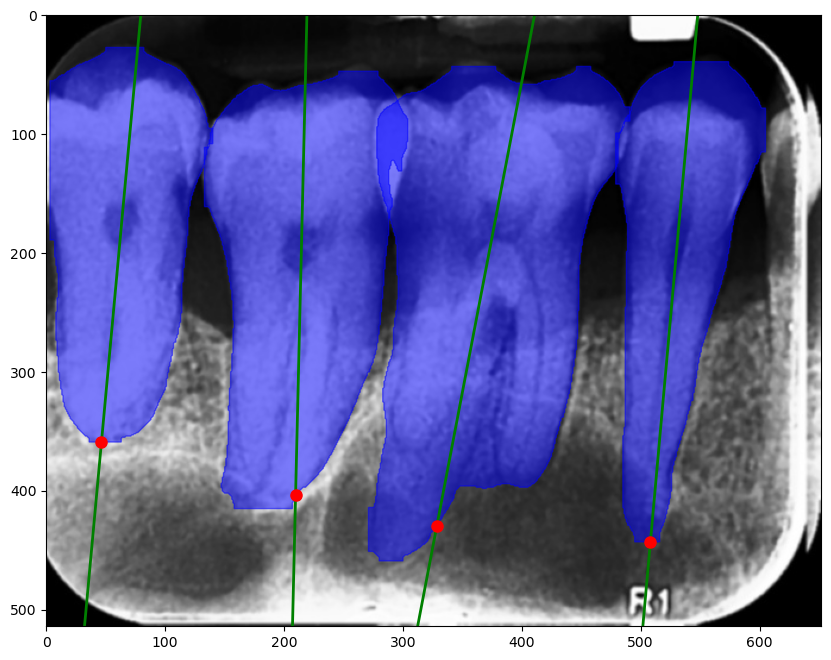

In [812]:
roots = find_lower_intersection(major_axes=major_axes, polygons= tooth_polygons)
plot_results(image, tooth_polygons, major_axes, roots)

In [813]:
def find_lower_intersections_for_shape(polygon, axes):
    """
    Finds the lower (higher y-coordinate) intersection points of multiple axes with a single polygon.

    Parameters:
        polygon (shapely.geometry.Polygon): The shape (polygon).
        axes (list of shapely.geometry.LineString): List of major axes (lines).

    Returns:
        List of the lowest intersection points (shapely.geometry.Point or None if no intersection).
    """
    lower_intersections = []

    # Get the polygon's border as a LineString
    polygon_border = LineString(polygon.exterior.coords)

    for axis in axes:
        # Compute intersection of the line with the polygon border
        intersection = axis.intersection(polygon_border)

        # Check if we have multiple intersection points
        if isinstance(intersection, MultiPoint):
            # Get the lower intersection (largest y-coordinate)
            lowest_point = max(intersection.geoms, key=lambda p: p.y)
            lower_intersections.append(lowest_point)

        elif isinstance(intersection, Point):
            lower_intersections.append(intersection)  # Single intersection

        else:
            lower_intersections.append(None)  # No intersection found

    return lower_intersections


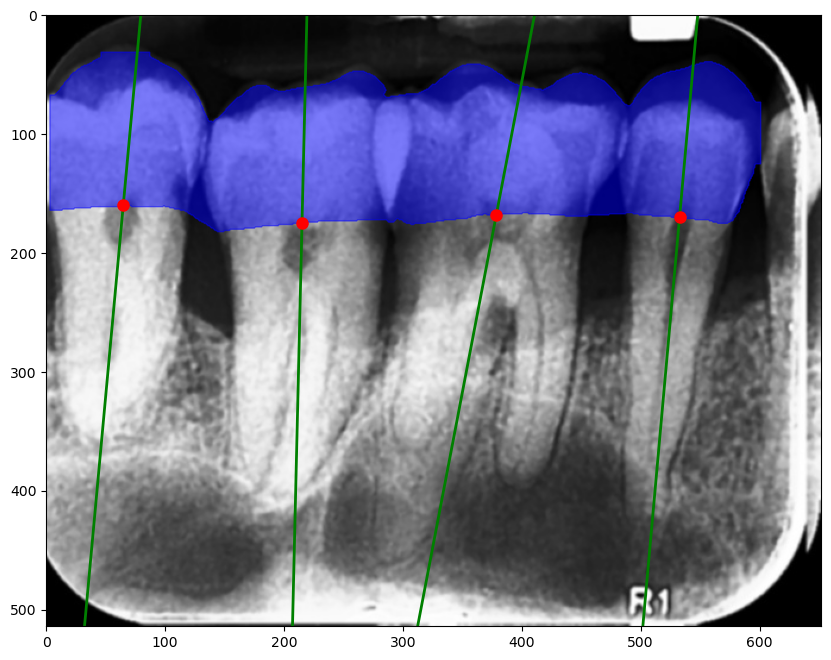

In [814]:
cejs = find_lower_intersections_for_shape(axes=major_axes, polygon= cej_polygon[-1])
plot_results(image, cej_polygon, major_axes, cejs)

In [815]:
def find_higher_intersections_for_shape(polygon, axes):
    """
    Finds the lower (higher y-coordinate) intersection points of multiple axes with a single polygon.

    Parameters:
        polygon (shapely.geometry.Polygon): The shape (polygon).
        axes (list of shapely.geometry.LineString): List of major axes (lines).

    Returns:
        List of the lowest intersection points (shapely.geometry.Point or None if no intersection).
    """
    lower_intersections = []

    # Get the polygon's border as a LineString
    polygon_border = LineString(polygon.exterior.coords)

    for axis in axes:
        # Compute intersection of the line with the polygon border
        intersection = axis.intersection(polygon_border)

        # Check if we have multiple intersection points
        if isinstance(intersection, MultiPoint):
            # Get the lower intersection (largest y-coordinate)
            lowest_point = min(intersection.geoms, key=lambda p: p.y)
            lower_intersections.append(lowest_point)

        elif isinstance(intersection, Point):
            lower_intersections.append(intersection)  # Single intersection

        else:
            lower_intersections.append(None)  # No intersection found

    return lower_intersections


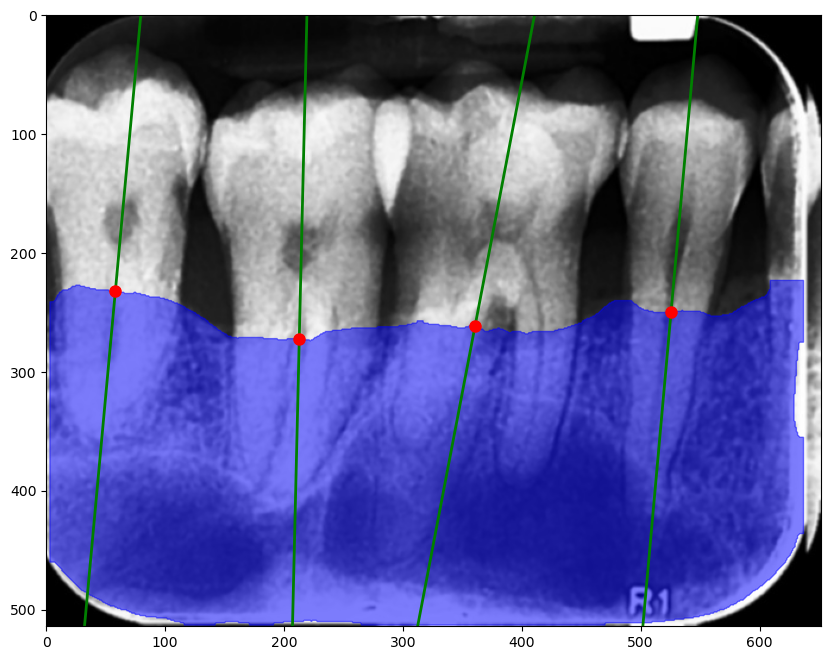

In [816]:
bone_levels = find_higher_intersections_for_shape(axes=major_axes, polygon=bone_polygon[-1])

plot_results(image, bone_polygon, major_axes, bone_levels)

In [817]:
from shapely.geometry import Point
import numpy as np

def calculate_pairwise_distances(list1, list2):
    """
    Calculates the Euclidean distance between corresponding points in two lists.

    Parameters:
        list1 (list of shapely.geometry.Point): First list of points.
        list2 (list of shapely.geometry.Point): Second list of points.

    Returns:
        List of distances (float values).
    """
    if len(list1) != len(list2):
        raise ValueError("Both lists must have the same length.")

    distances = [
        np.sqrt((p2.x - p1.x) ** 2 + (p2.y - p1.y) ** 2)
        for p1, p2 in zip(list1, list2)
    ]

    return distances

In [818]:
distances1 = calculate_pairwise_distances(roots, bone_levels)

distances2 = calculate_pairwise_distances(bone_levels, cejs)


In [819]:
np.array(distances2) / np.array(distances1)

array([    0.56758,       0.552,     0.73869,     0.41451])

In [820]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from PIL import Image

def calculate_pairwise_distances(list1, list2):
    """
    Calculates the Euclidean distance between corresponding points in two lists.

    Parameters:
        list1 (list of shapely.geometry.Point): First list of points.
        list2 (list of shapely.geometry.Point): Second list of points.

    Returns:
        List of distances (float values).
    """
    if len(list1) != len(list2):
        raise ValueError("Both lists must have the same length.")

    distances = [
        np.sqrt((p2.x - p1.x) ** 2 + (p2.y - p1.y) ** 2)
        for p1, p2 in zip(list1, list2)
    ]

    return distances

def plot_points_and_ratios(list1, list2, list3, image, d1, d2):
    """
    Plots the points from three lists on an image and displays the ratio of pairwise distances (d1/d2).

    Parameters:
        list1, list2, list3 (list of shapely.geometry.Point): Lists of points.
        image (PIL.Image or np.ndarray): The background image.
        d1, d2 (list of float): Pairwise distances calculated for list1/list2 and list2/list3.
    """
    # Ensure image is a PIL image
    if isinstance(image, np.ndarray):
        img = Image.fromarray(image)  # Convert NumPy array to PIL image
    else:
        img = image  # Use as-is if already a PIL image

    # Calculate the ratios d1/d2
    ratios = [d1_value / d2_value if d2_value != 0 else 0 for d1_value, d2_value in zip(d1, d2)]

    # Plot the image
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(img)

    # Plot the points from list1, list2, list3
    for i, point in enumerate(list1):
        ax.plot(point.x, point.y, 'bo', label=f"Point1-{i+1}")

    for i, point in enumerate(list2):
        ax.plot(point.x, point.y, 'go', label=f"Point2-{i+1}")

    for i, point in enumerate(list3):
        ax.plot(point.x, point.y, 'ro', label=f"Point3-{i+1}")

    # Annotate distances and ratios between points
    for i, (d1_value, d2_value, ratio) in enumerate(zip(d1, d2, ratios)):
        # ax.text(list1[i].x, list1[i].y, f"D1: {d1_value:.2f}", fontsize=12, color='blue', ha='right')
        # ax.text(list2[i].x, list2[i].y, f"D2: {d2_value:.2f}", fontsize=12, color='green', ha='right')
        ax.text(list2[i].x, list2[i].y - 10, f"Ratio: {ratio:.2f}", fontsize=12, color='red', ha='center')

    # ax.legend()
    ax.set_xlim(0, img.width)
    ax.set_ylim(img.height, 0)  # Invert y-axis to align with image coordinates
    ax.axis(False)
    plt.show()

def process_and_plot(list1, list2, list3, image):
    """
    Process the three point lists, calculate distances and ratios, and plot them on an image.
    """
    # Calculate pairwise distances between the lists
    d1 = calculate_pairwise_distances(list1, list2)
    d2 = calculate_pairwise_distances(list2, list3)

    # Plot the points and distances on the image
    plot_points_and_ratios(list1, list2, list3, image, d1, d2)


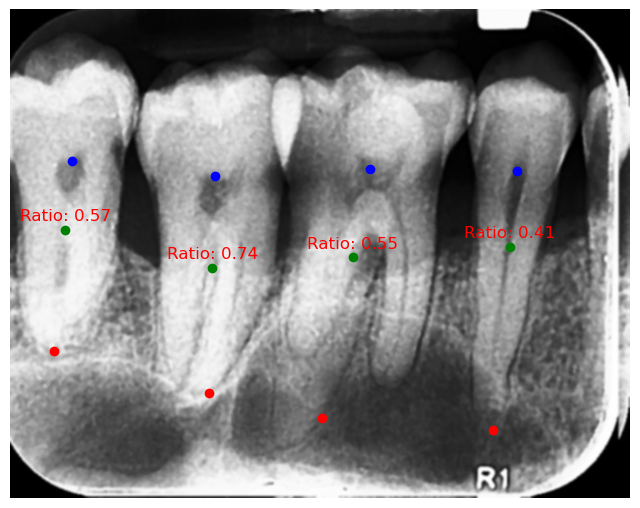

In [821]:
process_and_plot(cejs, bone_levels, roots, image)